In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

(train_ds, test_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#print(ds_info)
#tfds.show_examples(train_ds,ds_info)
#print(np.amax(train_ds))

'get range of pixels in image?'

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


'get range of pixels in image?'

In [2]:
def prepare_mnist_dataset(mnist):
  # flatten images 
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  # cast img type to float
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  # normalize values
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  # onehot encoding
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth = 10)))
  # cache progress in memory
  mnist = mnist.cache()
  # shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(128)
  mnist = mnist.prefetch(20)

  return mnist

#train_dataset = train_ds.apply(prepare_mnist_dataset)
#test_dataset = test_ds.apply(prepare_mnist_dataset)


In [3]:
def prepare_mnist_dataset_short(mnist):
  mnist = mnist.map(lambda img, target: ((tf.cast(tf.reshape(img, (-1,)), tf.float32)/128.)-1., tf.one_hot(target, depth=10))).cache().shuffle(1000).batch(32).prefetch(20)
  return mnist
train_dataset = train_ds.apply(prepare_mnist_dataset_short)
test_dataset = test_ds.apply(prepare_mnist_dataset_short)

In [13]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(128, activation=tf.nn.relu)

    self.out = tf.keras.layers.Dense(10, activation= tf.nn.sigmoid) #tf.nn.softmax)

  @tf.function
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.out(x)
    return x

In [14]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test_step(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis=1))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [12]:
num_epochs = 10
learning_rate = 0.01

# Initialize the model
model = MyModel()
cross_entropy_loss = tf.keras.losses.CategoricalHinge()#CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()#SGD(learning_rate, momentum = 0.03)

# visualization lists
train_losses = []
test_losses = []
test_accuracies = []

# testing on test data before begin
test_loss, test_accuracy = test_step(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# testing on test data before begin
train_loss, _ = test_step(model, train_dataset, cross_entropy_loss)
train_losses.append(test_loss)

# train for epochs
for epoch in range(num_epochs):
  # why here test_accuracies[-1]
  print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')  

  epoch_loss_agg = []
  for input, target in train_dataset:
    train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    epoch_loss_agg.append(train_loss)

  train_losses.append(tf.reduce_mean(epoch_loss_agg))

  test_loss, test_accuracy = test_step(model, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


Epoch: 0 starting with accuracy 0.08117012779552715
Epoch: 1 starting with accuracy 0.9358027156549521
Epoch: 2 starting with accuracy 0.9499800319488818
Epoch: 3 starting with accuracy 0.9543730031948882
Epoch: 4 starting with accuracy 0.9550718849840255
Epoch: 5 starting with accuracy 0.954173322683706
Epoch: 6 starting with accuracy 0.9553714057507987
Epoch: 7 starting with accuracy 0.9580670926517572
Epoch: 8 starting with accuracy 0.9661541533546326
Epoch: 9 starting with accuracy 0.9621605431309904


final training loss: 0.06617897748947144  final test loss: 0.07109115272760391    final test accuracy: 0.9656549520766773


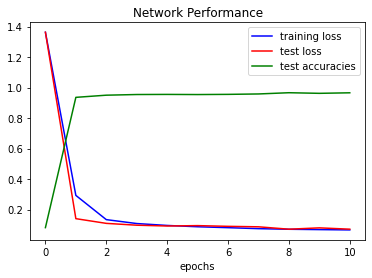

In [15]:
import matplotlib.pyplot as plt

def plot(train_losses, test_losses, test_accuracies):
  line1, = plt.plot(train_losses, 'b-', label='training loss')
  line2, = plt.plot(test_losses, 'r-', label='test loss')
  line3, = plt.plot(test_accuracies, 'g-', label='test accuracies')

  plt.title('Network Performance')
  plt.xlabel('epochs')
  plt.legend(handles=[line1,line2,line3])
  plt.show

plot(train_losses, test_losses, test_accuracies)
print(f'final training loss: {train_losses[-1]}  final test loss: {test_losses[-1]}    final test accuracy: {test_accuracies[-1]}')

Throughout training we kept the epochs at 10 as increasing them would have lead to more waiting time.
When using the SGD optimizer we found that a learning rate of 0,05 outperformed rates of 0.1, 0.01 and 0.001. And 2 hidden layers of 512 units outperformed 3 layers of 256 units. We also tried out several different activation functions and in this case the ReLU outperformed the sigmoid aswell as the tanh. 
As this is a categorical classifaction task we tried the two different methods Categorical crossentropy and Categorical Hinge, in this case Categorical crossentropy worked better.

In order to create a relatively "cost efficient" model we decided to increase the batch size to 128 (higher might have also increased accuracy) and decrease the unit amount of the two hidden layers to 128.
As an optimizer we used Adam, keeping all the defaults the same, as changing the learning rate seemed to lead to drastically worse performance.
This model lead to a final test accuracy: 0.965 which is comparable to the best final test accuracy from previous models of max:  0.979.